# Lyrics detector Challenge

The goal for this challenge is to leverage your knowledge of Deep Learning to design and train a lyrics classifier. For a given verse $X$, our model should learn to predict the artist $y$. The dataset consists of lyrics scrapped from the Genius website.

### Objectives:
- Text preprocessing
- Text embedding
- Train a RNN to detect the artist behind a set of lyrics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

## 1. Data Cleaning

Our dataset contains around 4,000 verses of lyrics from different artists: Drake, Ed Sheeran and Kanye West (the verses are given in this order).

In [2]:
raw_data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/verses.csv")
data = raw_data.copy() # From now on, update `data` as you see fit and don't touch raw_data
data.head()

,artist,verse
0,Drake,"Ayy, woah Ayy, ayy Yeah"
1,Drake,I'm makin' a change today The liquor been taki...
2,Drake,"I can't just be with you and only you Yeah, I ..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne..."
4,Drake,I'm makin' a change today The liquor been taki...


In [3]:
data.head(20)

,artist,verse
0,Drake,"Ayy, woah Ayy, ayy Yeah"
1,Drake,I'm makin' a change today The liquor been taki...
2,Drake,"I can't just be with you and only you Yeah, I ..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne..."
4,Drake,I'm makin' a change today The liquor been taki...
5,Drake,"Ayy, yeah I got one, Laurie got one and that t..."
6,Drake,"Well, summer, all I did was rest, okay? And Ne..."
7,Drake,I'm makin' a change today The liquor been taki...
8,Drake,(Six) Yeah Yeah Yeah
9,Drake,"Leave me out the comments, leave me out the no..."


❓ **Have a look at the verse index 18th**. 
- What do you observe?
- Clean verses from non standard characters using [`unidecode.unidecode()`](https://pypi.org/project/Unidecode/)

In [4]:
data.loc[18,'verse']

'Ayy, yeah Pipe this shit up and I turn this shit up When I was down, I\u2005was\u2005down Now them diamonds\u2005for fun like damn Ayy, yeah'

In [5]:
# YOUR CODE HERE
from unidecode import unidecode
data['verse'] = data['verse'].apply(lambda x:unidecode(x))

In [6]:
data.loc[18,'verse']

'Ayy, yeah Pipe this shit up and I turn this shit up When I was down, I was down Now them diamonds for fun like damn Ayy, yeah'

❓ **Check if some verses are duplicated.** 
- It can be frequent in music lyrics.
- If so, remove them to avoid data leaks between train and test sets

In [7]:
len(data)

3975

In [8]:
# YOUR CODE HERE
data = data.drop_duplicates()
data.reset_index(inplace=True)
data.drop(columns=['index'],inplace=True)

In [9]:
len(data)

3031

In [10]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_loading',
    shape=data.shape,
    verses=data.verse[:50]
)

result.write()

## 2. Data Analysis (given to you)

👉 **We check the number of unique artist and the number of verses per artist**

In [11]:
data.artist.value_counts()

Drake         1391
Ed Sheeran     861
Kanye West     779
Name: artist, dtype: int64

👉 **For each artist, let's have a look at the top-10 most used words to see if they look similar?**

We'll use Tensorflow's [`Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)'s index_word

In [12]:
drake = data[data.artist =='Drake'].verse
ed = data[data.artist =='Ed Sheeran'].verse
kanye = data[data.artist =='Kanye West'].verse

In [13]:
tokenizer_drake = tf.keras.preprocessing.text.Tokenizer()
tokenizer_ed = tf.keras.preprocessing.text.Tokenizer()
tokenizer_kanye = tf.keras.preprocessing.text.Tokenizer()

tokenizer_drake.fit_on_texts(drake)
tokenizer_ed.fit_on_texts(ed)
tokenizer_kanye.fit_on_texts(kanye)

In [14]:
pd.DataFrame(data={
    "Drake": pd.Series(tokenizer_drake.index_word)[:10],
    "Ed Sheeran": pd.Series(tokenizer_ed.index_word)[:10],
    "Kanye West": pd.Series(tokenizer_kanye.index_word)[:10],
})

,Drake,Ed Sheeran,Kanye West
1,i,i,i
2,you,you,the
3,the,the,you
4,and,and,and
5,to,me,to
6,a,my,a
7,it,to,my
8,me,a,it
9,i'm,in,me
10,my,i'm,in


👉 **Let's quantify how much vocabulary do they have in common**

- An artist **vocabulary** is the **set** of all unique used words
- We compute the `ratio` of (i) the length of vocabulary they **share**, over (ii) the length of the **total** vocabulary of the dataset

<details>
    <summary>Hints</summary>

We'll use Python [`set.intersection()`](https://www.programiz.com/python-programming/methods/set/intersection) and [`set.union()`](https://www.programiz.com/python-programming/methods/set/union)
</details>

In [15]:
drake_vocabulary = set(tokenizer_drake.index_word.values())
ed_vocabulary = set(tokenizer_ed.index_word.values())
kanye_vocabulary = set(tokenizer_kanye.index_word.values())

In [16]:
common_vocabulary = drake_vocabulary.intersection(ed_vocabulary).intersection(kanye_vocabulary)
global_vocabulary = drake_vocabulary.union(ed_vocabulary).union(kanye_vocabulary)

ratio = len(common_vocabulary)/len(global_vocabulary)
print(f"{ratio*100:.2f}% of the artists' vocabulary is common")

15.28% of the artists' vocabulary is common


In [17]:
len(global_vocabulary)

12763

## 3. Data Preprocessing

### 3.1 Word Embedding
We now need to think about embedding our sentences into numbers. We will be using [`gensim.models.Word2Vec`](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) to embed each word of the sentence and concatenate the embeddings of the words forming the sentence.

❓ **Transform the list of strings (verses) into a list of word sequences (a word sequence is a list of words contained in a string)**
- Store these sequences of words in a new column `data["seq"]` in your dataframe
- You can use `tensorflow.keras.preprocessing.text.text_to_word_sequence` 

In [18]:
def sequence_text(text):
    return tf.keras.preprocessing.text.text_to_word_sequence(text)

In [19]:
data["seq"] = data['verse'].apply(lambda x:sequence_text(x))

In [20]:
data.head()

,artist,verse,seq
0,Drake,"Ayy, woah Ayy, ayy Yeah","[ayy, woah, ayy, ayy, yeah]"
1,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b..."
2,Drake,"I can't just be with you and only you Yeah, I ...","[i, can't, just, be, with, you, and, only, you..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne...","[well, summer, all, i, did, was, rest, okay, a..."
4,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b..."


❓ **Let's check if we can cap the length of each sequences without losing too much information**
- Plot the distribution of sequences lengths using the [`seaborn.kdeplot`](https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn-displot) function
- Does it seem reasonable to limit ourself to 300 words per verse later on? 

In [21]:
# YOUR CODE HERE
data['len_sequence'] = data['seq'].apply(lambda x : len(x))

<AxesSubplot:xlabel='len_sequence', ylabel='Density'>

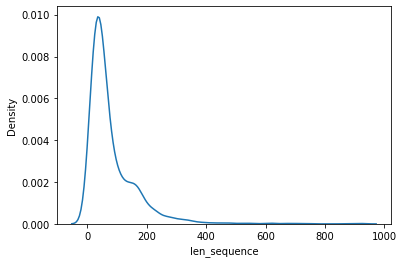

In [22]:
sns.kdeplot(x='len_sequence',data=data)

**it seems reasonnable to keep ony the first 300 words as more than 90% of sequences have less.**

❓ **Keep only the first `300` words of each sequences to reduce the useless long tail of long verses**

In [23]:
data['seq'] = data['seq'].apply(lambda x: x[:300])

In [24]:
data['len_sequence'] = data['seq'].apply(lambda x : len(x))

<AxesSubplot:xlabel='len_sequence', ylabel='Density'>

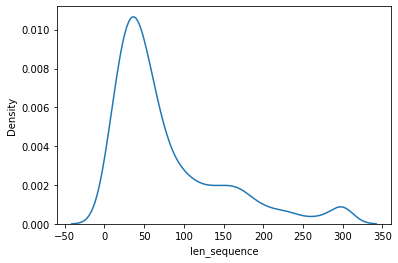

In [25]:
sns.kdeplot(x='len_sequence',data=data)

❓ **Train a `gensim.models.Word2Vec` model on your dataset** 
- You want to embed each word into vectors of dimension `100`
- No words should be excluded
- Give Word2Vec at least 50 epochs to be sure it converges
- Store these lists of vectors in a new column `data["embed"]`

In [26]:
from gensim.models import Word2Vec

/Users/jauffret/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [27]:
word2vec = Word2Vec(sentences=data['seq'])

In [28]:
word2vec.train(data['seq'],epochs=50,total_examples=len(data['seq']))

(7791570, 11871000)

In [29]:
def embed_sentence(word2vec, sentence):
    embed =[]
    for word in sentence:
        try:
            word_vec = word2vec.wv[word]
            embed.append(word_vec)
        except:
            next
    return np.array(embed)

In [30]:
data['embed']=data['seq'].apply(lambda x: embed_sentence(word2vec, x))

In [31]:
# Check 
assert len(data['embed']) == len(data)

### 3.2 Create (X,y)

❓ **Create your numpy array `X` of shape (number_of_verses, 300, 100)**

- 300 words per verse (pad verses shorter than 300 with zeros at the end) 
- each words being a vector of size 100

<img src="https://raw.githubusercontent.com/lewagon/data-images/master/DL/padding.png" width=400>

In [32]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X = pad_sequences(data['embed'], maxlen=300, dtype='float32', padding='post', value=0)

In [33]:
X.shape

(3031, 300, 100)

❓ **Create the numpy array `y` of shape `(n_verses, 3)` that contains the one-hot-encoded list of labels, for the RNN**

In [34]:
data.artist.value_counts()

Drake         1391
Ed Sheeran     861
Kanye West     779
Name: artist, dtype: int64

In [35]:
from sklearn.preprocessing import OneHotEncoder

In [36]:
ohe = OneHotEncoder(sparse = False)
ohe.fit(data[['artist']])
y = ohe.transform(data[['artist']])

In [37]:
y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [38]:
y.shape

(3031, 3)

👉 We train/test split the dataset below for you

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [40]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_preprocessing',
    n_zeros = np.sum(X == 0),
    X_shape = X.shape,
    y_shape = y.shape,
)

result.write()

## 4. Recurrent Neural Network

👉 Run this code below if you haven't managed to build your own (X,Y) training sets. This will load them as solution

```python
! wget \
'https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_lyrics_solution.pickle'

import pickle
with open("data_lyrics_solution.pickle", "rb") as file:
    (X_train, y_train, X_test, y_test) = pickle.load(file)
    
! rm data_lyrics_solution.pickle
```

❓ **First, store your baseline accuracy to beat as `score_baseline`**
- Consider predicting always the most frequent artist

In [41]:
# YOUR CODE HERE
score_baseline=1/3

❓ **Create a RNN architecture to predict the artists `y`  given verses `X`** :

- Keep it simple: use only one LSTM layer and one *hidden* dense layer between the input and output layers
- Don't forget to take care of fake "zeros" added during preprocessing
- Store it into the `model` variable.

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [43]:
# YOUR CODE HERE
def init_model():
    model = Sequential()
    model.add(layers.Masking())
    model.add(layers.LSTM(20, activation='tanh'))
    model.add(layers.Dense(3, activation='softmax'))
    
    #Compile
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

In [44]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=3)

❓ **Train your `model` on the `(X_train, y_train)` training set**
- Use an appropriate loss
- Adapt the learning rate of your optimizer if convergence is too slow/fast
- Make sure your model does not overfit with appropriate control techniques

💡 You will not be judged by the computing power of your computer, you can reach decent performance in less than 3 minutes of training without GPUs.

In [45]:
model = init_model()

In [46]:
# YOUR CODE HERE
history = model.fit(X_train,
                    y_train, 
                    epochs=50, 
                    callbacks=[es], 
                    validation_split=0.2)

Epoch 1/50
61/61 [==============================] - 19s 231ms/step - loss: 1.0888 - accuracy: 0.4042 - val_loss: 1.0081 - val_accuracy: 0.4763
Epoch 2/50
61/61 [==============================] - 11s 188ms/step - loss: 0.9634 - accuracy: 0.5405 - val_loss: 0.9589 - val_accuracy: 0.5299
Epoch 3/50
61/61 [==============================] - 13s 221ms/step - loss: 0.8701 - accuracy: 0.6107 - val_loss: 0.9168 - val_accuracy: 0.5629
Epoch 4/50
61/61 [==============================] - 12s 190ms/step - loss: 0.7948 - accuracy: 0.6511 - val_loss: 0.8786 - val_accuracy: 0.5876
Epoch 5/50
61/61 [==============================] - 11s 173ms/step - loss: 0.7422 - accuracy: 0.6956 - val_loss: 0.8419 - val_accuracy: 0.6000
Epoch 6/50
61/61 [==============================] - 10s 172ms/step - loss: 0.6526 - accuracy: 0.7343 - val_loss: 0.8652 - val_accuracy: 0.5938
Epoch 7/50
61/61 [==============================] - 10s 170ms/step - loss: 0.6190 - accuracy: 0.7494 - val_loss: 0.8027 - val_accuracy: 0.6474

❓ **Plot the training and validation losses through training**

In [47]:
def plot_history(history, metric):
    plt.plot(history.history[f'{metric}'])
    plt.plot(history.history[f'val_{metric}'])
    plt.title(f'Model {metric}')
    plt.ylabel(f'{metric}')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='best')
    plt.show()

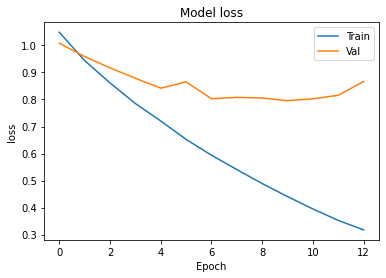

<Figure size 432x288 with 0 Axes>

In [53]:
# Plot below your train/val loss history
plot_history(history,'loss')


# Run also this code to save figure as jpg in path below (it's your job to ensure it works)
fig = plt.gcf()
plt.savefig("tests/history.jpg")

❓ **Save your accuracy on test set as `score_test`**

In [49]:
# YOUR CODE HERE
score_test = model.evaluate(X_test,y_test)[1]

19/19 [==============================] - 1s 40ms/step - loss: 0.8274 - accuracy: 0.6787


In [50]:
score_test

0.6787479519844055

🧪 **Send your results below**

In [54]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "network",
    loss = model.loss,
    input_shape = list(model.input.shape),
    layer_names = [layer.name for layer in model.layers],
    final_activation = model.layers[-1].activation.__wrapped__._keras_api_names[0],
    score_baseline = score_baseline,
    score_test = score_test,
)
result.write()